In [1]:
pip install yfinance

In [2]:
pip install seaborn

In [3]:
pip install statsmodels

In [4]:
pip install pandas

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 5

In [5]:
pip install matplotlib numpy pandas cufflinks plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00


In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

##Explaining stock returns' volatility with ARCH models

In [7]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 11.6 MB/s eta 0:00:00


In [20]:
import pandas as pd
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt

In [21]:
RISKY_ASSET = 'ADRO.JK'
START_DATE = '2018-01-01'
END_DATE = '2023-12-31'

In [22]:
# Download the data without the 'adjusted' parameter
df = yf.download(RISKY_ASSET,
                start=START_DATE,
                end=END_DATE)

# If you need adjusted closing prices, you can calculate them manually
df['Adj Close'] = df['Close'] * df['Adj Close'] / df['Close']

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed

Downloaded 1492 rows of data.


###Daily Returns

Average return: Ticker
ADRO.JK    0.1
dtype: float64%


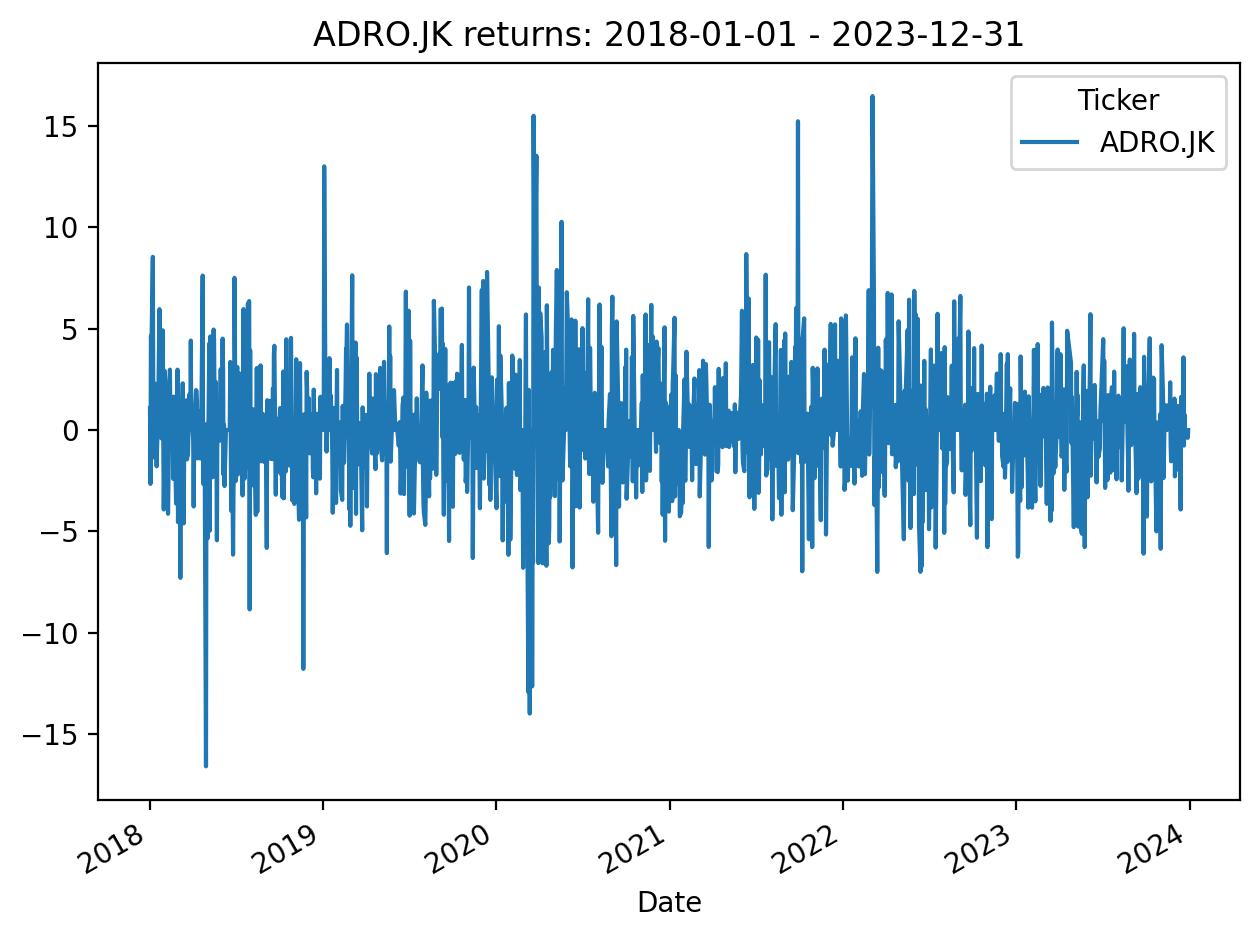

In [23]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.name = 'asset_returns'
print(f'Average return: {round(returns.mean(), 2)}%')
returns.plot(title=f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}');

plt.tight_layout()
plt.show()

In [24]:
model = arch_model(returns, mean='Zero', vol='ARCH', p=1, o=0, q=0)

###Estimate the model and print the summary:

In [25]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                ADRO.JK   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3688.92
Distribution:                  Normal   AIC:                           7381.83
Method:            Maximum Likelihood   BIC:                           7392.45
                                        No. Observations:                 1491
Date:                Fri, Nov 29 2024   Df Residuals:                     1491
Time:                        02:43:48   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          7.6773      0.588     13.048  6.497e-39    [  

###Plot the residuals and the conditional volatility:

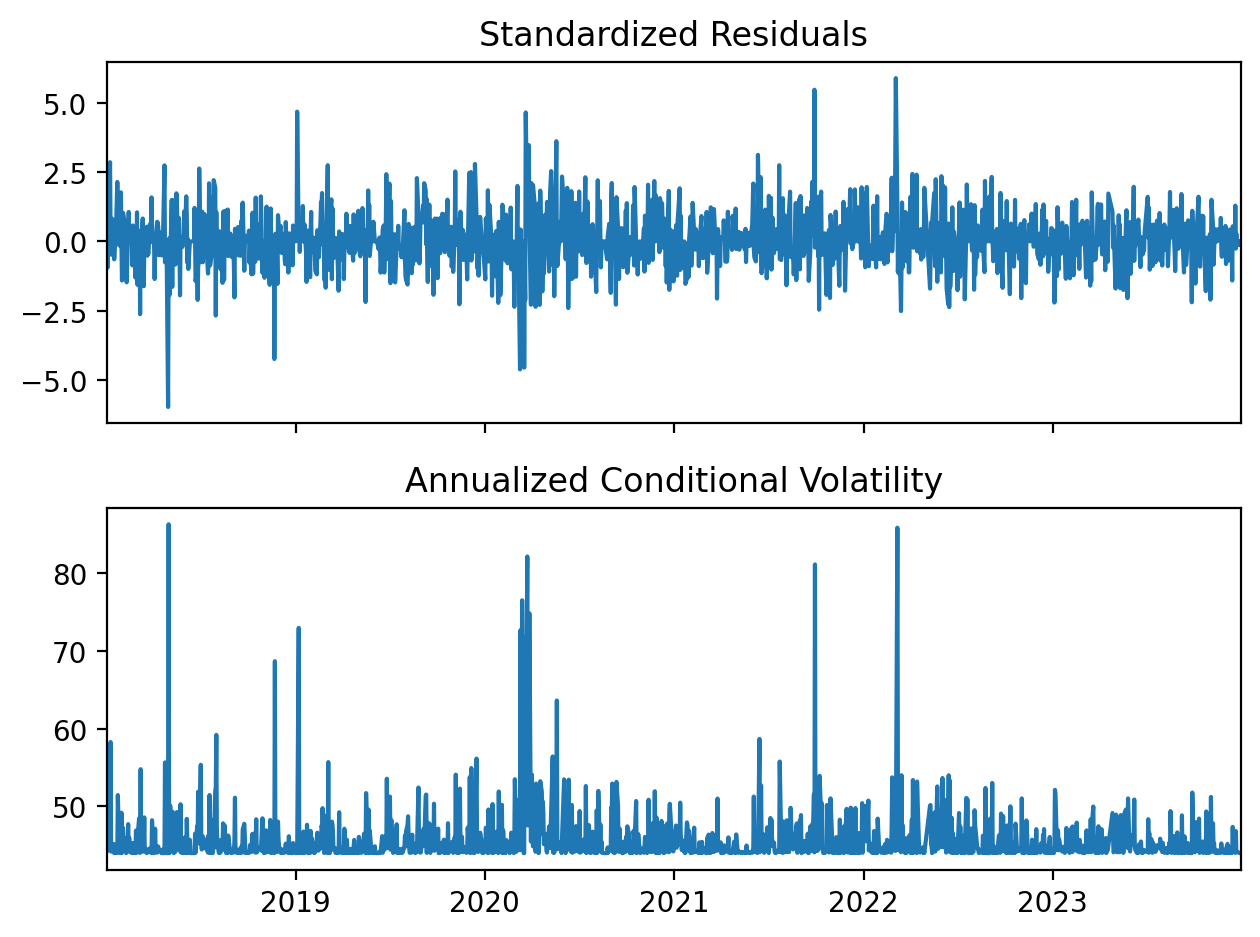

In [26]:
model_fitted.plot(annualize='D')

plt.tight_layout()
plt.show()

#Explaining stock returns' volatility with GARCH models

In [27]:
model = arch_model(returns, mean='Zero', vol='GARCH',
                  p=1, o=0, q=1)

In [28]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                ADRO.JK   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3645.22
Distribution:                  Normal   AIC:                           7296.44
Method:            Maximum Likelihood   BIC:                           7312.36
                                        No. Observations:                 1491
Date:                Fri, Nov 29 2024   Df Residuals:                     1491
Time:                        02:44:05   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.8057      0.276      2.916  3.551e-03   [  0.26

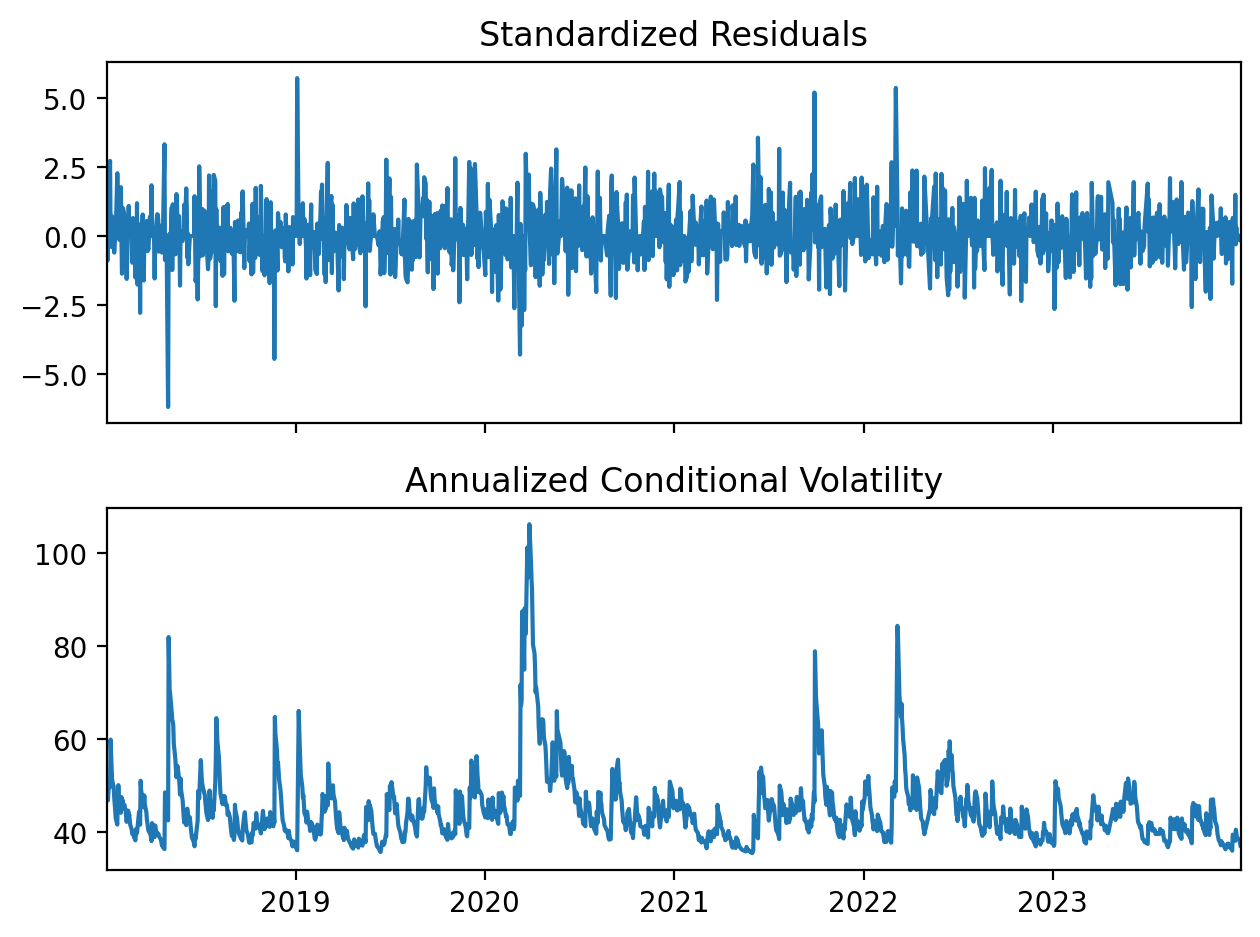

In [29]:
model_fitted.plot(annualize='D')

plt.tight_layout()
plt.show()

#Implementing CCC-GARCH model for multivariate volatility forecasting

In [30]:
import pandas as pd
import yfinance as yf
from arch import arch_model
import numpy as np

In [31]:
RISKY_ASSETS = ['BBRI.JK', 'BBNI.JK', 'BBCA.JK']
N = len(RISKY_ASSETS)
START_DATE = '2018-01-01'
END_DATE = '2023-12-31'

In [32]:
# Download the data without the 'adjusted' argument
df = yf.download(RISKY_ASSETS,
                start=START_DATE,
                end=END_DATE)

# If you need adjusted closing prices, you can calculate them manually:
# df['Adj Close'] = df['Close'] * df['Adj Close'] / df['Close']

print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  3 of 3 completed

Downloaded 1493 rows of data.


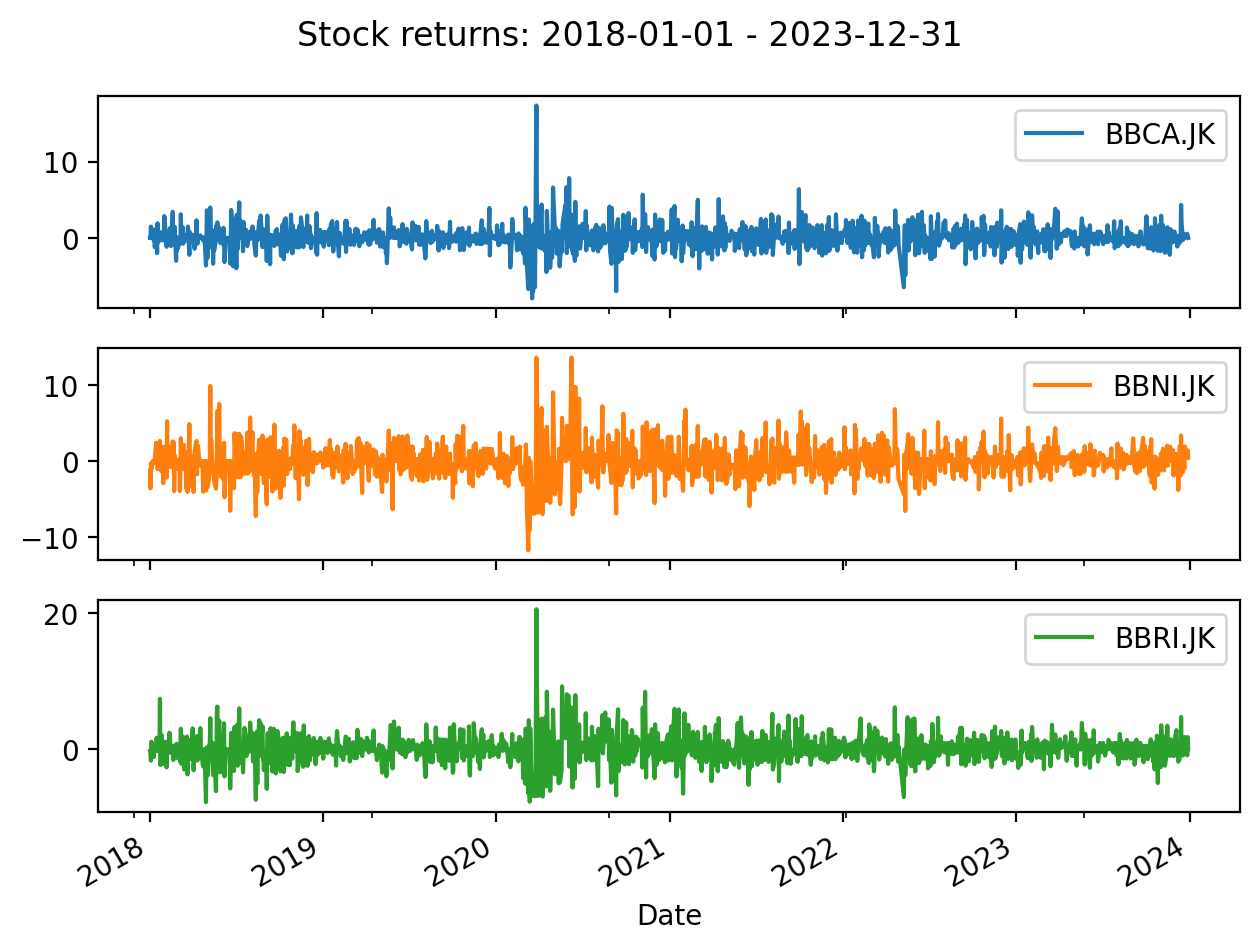

In [33]:
returns = 100 * df['Adj Close'].pct_change().dropna()
returns.plot(subplots=True,
            title=f'Stock returns: {START_DATE} - {END_DATE}')

plt.tight_layout()
plt.show()

In [34]:
coeffs = []
cond_vol = []
std_resids = []
models = []

In [35]:
for asset in returns.columns:
    # specify and fit the model
    model = arch_model(returns[asset], mean='Constant',
                      vol='GARCH', p=1, o=0, q=1).fit(update_freq=0,
                                                     disp='off')
    # store results in the lists
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.resid / model.conditional_volatility)
    models.append(model)

In [36]:
cond_vol_df = pd.DataFrame(cond_vol).transpose() \
                .set_axis(returns.columns,
                         axis='columns',
                         copy=False)  # Replace inplace=False with copy=False
std_resids_df = pd.DataFrame(std_resids).transpose() \
                .set_axis(returns.columns,
                         axis='columns',
                         copy=False)  # Replace inplace=False with copy=False

In [39]:
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
coeffs_df

,mu,omega,alpha[1],beta[1]
Ticker,,,,
BBCA.JK,0.105617,0.134308,0.108546,0.829470
BBNI.JK,0.077032,0.056382,0.061384,0.926537
BBRI.JK,0.112192,0.099833,0.084956,0.888688


In [40]:
R = std_resids_df.transpose() \
                 .dot(std_resids_df) \
                 .div(len(std_resids_df))

In [41]:
# define objects
diag = []
D = np.zeros((N, N))

# populate the list with conditional variances
for model in models:
    diag.append(model.forecast(horizon=1).variance.values[-1][0])
# take the square root to obtain volatility from variance
diag = np.sqrt(np.array(diag))
# fill the diagonal of D with values from diag
np.fill_diagonal(D, diag)

# calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D)

In [42]:
H

array([[1.30621788, 0.85499884, 0.85869114],
       [0.85499884, 2.58485238, 1.47087855],
       [0.85869114, 1.47087855, 2.43128263]])

In [43]:
import yfinance as yf
import pandas as pd

# Define the tickers and date range
tickers = ['BBCA.JK', 'BBNI.JK', 'BBRI.JK']
start_date = '2018-01-01'
end_date = '2023-12-31'

# Download the data
data = yf.download(tickers, start=start_date, end=end_date)

# Calculate daily returns
returns = data['Adj Close'].pct_change().dropna()

# Save to CSV
returns.to_csv('stock_returns.csv')

print('Stock returns saved to stock_returns.csv')

[*********************100%***********************]  3 of 3 completed

Stock returns saved to stock_returns.csv


#Forecasting the conditional covariance matrix using DCC-GARCH (Using Python and R)

In [44]:
import pandas as pd

In [45]:
%load_ext rpy2.ipython

In [46]:
%%R

#install.packages('rmgarch', repos = "http://cran.us.r-project.org")
library(rmgarch)


Error in library(rmgarch) : there is no package called ‘rmgarch’


In [47]:
# Install R in Colab
!apt-get install r-base

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
r-base is already the newest version (4.4.2-1.2204.0).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [48]:
# Install the rpy2 package for Python-R integration
!pip install rpy2

In [49]:
%%R
install.packages(c("Rcpp", "RcppArmadillo", "rmgarch"))

(as ‘lib’ is unspecified)


























































































































































	‘/tmp/Rtmpy5PBI6/downloaded_packages’



In [50]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


###Import dataset into R

In [51]:
%%R

# Import the CSV file
mydata <- read.csv("/content/stock_returns.csv")

# Print the first 5 rows
print(head(mydata, 5))

                       Date     BBCA.JK      BBNI.JK      BBRI.JK
1 2018-01-02 00:00:00+00:00 0.000000000 -0.012626078 -0.002747217
2 2018-01-03 00:00:00+00:00 0.000000000 -0.035805498 -0.005509669
3 2018-01-04 00:00:00+00:00 0.014840168 -0.002652569 -0.016620580
4 2018-01-05 00:00:00+00:00 0.001124853 -0.010638367  0.011267761
5 2018-01-08 00:00:00+00:00 0.004494484  0.000000000  0.000000000


Model Specification

In [62]:
pip install arch numpy pandas matplotlib

In [63]:
pip install mgarch

In [75]:
!pip install arch # Install the correct package
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model # Import arch_model from the 'arch' package

# Fetch stock data
tickers = ["BBRI.JK", "BBNI.JK", "BBCA.JK"]
data = yf.download(tickers, start="2020-01-01", end="2024-01-01")['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

[*********************100%***********************]  3 of 3 completed


In [76]:
from arch import arch_model

# Fit GARCH models and extract standardized residuals
standardized_residuals = []
for ticker in tickers:
    garch = arch_model(returns[ticker], vol="Garch", p=1, q=1, mean="Zero", dist="normal")
    result = garch.fit(disp="off")
    standardized_residuals.append(result.std_resid)
    print(f"{ticker} GARCH(1,1) fitted:\n", result.summary())

standardized_residuals = np.column_stack(standardized_residuals)

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004722. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005119. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


BBRI.JK GARCH(1,1) fitted:
                        Zero Mean - GARCH Model Results                        
Dep. Variable:                BBRI.JK   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2511.03
Distribution:                  Normal   AIC:                          -5016.06
Method:            Maximum Likelihood   BIC:                          -5001.42
                                        No. Observations:                  973
Date:                Fri, Nov 29 2024   Df Residuals:                      973
Time:                        03:20:03   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.4548e-06  1.117e-

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0002797. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [92]:
from scipy.optimize import minimize
import numpy as np

def dcc_log_likelihood(params, residuals):
    a, b = params
    T, N = residuals.shape
    Qbar = np.cov(residuals.T)
    Qt = Qbar.copy()
    likelihood = 0

    for t in range(T):
        qt = (1 - a - b) * Qbar + a * np.outer(residuals[t], residuals[t]) + b * Qt
        # Regularization
        qt += np.eye(N) * 1e-6
        Qt = qt
        Rt = qt / np.sqrt(np.outer(np.diag(qt), np.diag(qt)))

        # Handle near-singularity using pseudo-inverse and condition number check
        if np.linalg.cond(Rt) < 1/np.finfo(Rt.dtype).eps:
            likelihood += np.log(np.linalg.det(Rt)) + residuals[t].T @ np.linalg.pinv(Rt) @ residuals[t]
        else:
            # If near-singular, skip the current iteration and penalize the likelihood
            likelihood += -np.inf

    return likelihood

# Optimization with adjusted bounds and Nelder-Mead method
initial_params = [0.01, 0.98]
bounds = [(0.001, 0.099), (0.801, 0.999)]  # Adjusted bounds
result = minimize(
    dcc_log_likelihood,
    initial_params,
    args=(standardized_residuals,),
    bounds=bounds,
    method="Nelder-Mead"  # Changed method
)

a_opt, b_opt = result.x
print(f"Optimized DCC Parameters: a={a_opt:.5f}, b={b_opt:.5f}")

Optimized DCC Parameters: a=0.09900, b=0.80100


Model Validation

In [97]:
# Format the output
distribution = "mvnorm"
model = "DCC(1,1)"
num_params_garch = len(tickers) * 4  # GARCH parameters
num_params_dcc = len(result.x) # DCC parameters
num_series = len(tickers)
num_obs = len(returns)
log_likelihood = -result.fun
avg_log_likelihood = log_likelihood / num_obs

header = f"""
Distribution         :  {distribution}
Model                :  {model}
No. Parameters       :
[VAR GARCH DCC UncQ] : [{num_series} {num_params_garch} {num_params_dcc} {num_series*(num_series-1)/2}]
No. Series           :  {num_series}
No. Obs.             :  {num_obs}
Log-Likelihood       :  {log_likelihood:.3f}
Av.Log-Likelihood    :  {avg_log_likelihood:.2f}
"""

print(header)


Distribution         :  mvnorm
Model                :  DCC(1,1)
No. Parameters       : 
[VAR GARCH DCC UncQ] : [3 12 2 3.0]
No. Series           :  3
No. Obs.             :  973
Log-Likelihood       :  -1648.721
Av.Log-Likelihood    :  -1.69



In [103]:
import numpy as np

def information_criteria(log_likelihood, num_params, num_obs):
    """
    Calculates various information criteria.

    Args:
        log_likelihood: The log-likelihood of the model.
        num_params: The number of parameters in the model.
        num_obs: The number of observations.

    Returns:
        A dictionary containing the Akaike, Bayes, Shibata, and Hannan-Quinn information criteria.
    """

    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(num_obs) - 2 * log_likelihood
    shibata = num_params * np.log(np.log(num_obs)) - 2 * log_likelihood
    hqic = 2 * num_params * np.log(np.log(num_obs)) - 2 * log_likelihood

    return {"Akaike": aic, "Bayes": bic, "Shibata": shibata, "Hannan-Quinn": hqic}


# Example usage (replace with your actual values)
log_likelihood = -result.fun  # from your code, assuming -result.fun is the log-likelihood value
num_params = len(result.x) # from your code, the optimized parameters
num_obs = len(returns) # from your code, your returns dataset

criteria = information_criteria(log_likelihood, num_params, num_obs)

for name, value in criteria.items():
    print(f"{name:<12}: {value:.3f}")

# Note: for elapsed time, use %timeit at the beginning of cell
# and capture the output in a variable. Then print out that variable
# within your script.

Akaike      : 3301.441
Bayes       : 3311.202
Shibata     : 3301.299
Hannan-Quinn: 3305.156


In [109]:
# Create a 3D array to store the forecasts
forecast_array = np.array(forecasted_variances)

# Display the forecasts
for i in range(forecast_array.shape[0]):  # Loop through forecast steps
    print(f", , {i+1}\n")  # Print step number
    print(forecast_array[i])  # Print the covariance matrix for that step
    print("\n")

, , 1

[[0.88580077 0.50815778 0.43436415]
 [0.50815778 0.88441582 0.43465886]
 [0.43436415 0.43465886 0.83219546]]


, , 2

[[0.80784038 0.46343369 0.3961348 ]
 [0.46343369 0.81324046 0.39640358]
 [0.3961348  0.39640358 0.75895299]]


, , 3

[[0.7453941  0.4276097  0.36551309]
 [0.4276097  0.756229   0.36576109]
 [0.36551309 0.36576109 0.70028577]]


, , 4

[[0.69537464 0.39891468 0.3409851 ]
 [0.39891468 0.71056281 0.34121646]
 [0.3409851  0.34121646 0.65329333]]


, , 5

[[0.65530904 0.37592997 0.32133819]
 [0.37592997 0.6739842  0.32155621]
 [0.32133819 0.32155621 0.61565238]]




In [111]:
# Assuming you have 'forecasted_variances'

# Extract the variances for each asset at each forecast step
asset1_variances = [forecast[0, 0] for forecast in forecasted_variances]
asset2_variances = [forecast[1, 1] for forecast in forecasted_variances]
asset3_variances = [forecast[2, 2] for forecast in forecasted_variances]

# Create a DataFrame for the output
forecast_df = pd.DataFrame({
    tickers[0]: asset1_variances,
    tickers[1]: asset2_variances,
    tickers[2]: asset3_variances
})

# Display the DataFrame
print(forecast_df)

    BBRI.JK   BBNI.JK   BBCA.JK
0  0.885801  0.884416  0.832195
1  0.807840  0.813240  0.758953
2  0.745394  0.756229  0.700286
3  0.695375  0.710563  0.653293
4  0.655309  0.673984  0.615652
